# Hücre 1 — Import + Path

In [2]:
import os, sys, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
MODELS_DIR = os.path.join(BASE_DIR, "models")
sys.path.insert(0, MODELS_DIR)

from relu import TinyCNN_ReLU
from leaky_relu import TinyCNN_LeakyReLU
from prelu import TinyCNN_PReLU

print("BASE_DIR  :", BASE_DIR)
print("MODELS_DIR:", MODELS_DIR)

BASE_DIR  : c:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\activation_functions\Core\PReLU
MODELS_DIR: c:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\activation_functions\Core\PReLU\models


# Hücre 2 — Seed + Device 

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Hücre 3 — Dataset / DataLoader (CIFAR10 örneği)

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 128
NUM_CLASSES = 10

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_set  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader), len(test_loader)

100%|██████████| 170M/170M [00:22<00:00, 7.73MB/s]   


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(391, 79)

# Hücre 4 — Train / Eval fonksiyonları

In [5]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct = 0, 0
    loss_sum = 0.0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum / total, correct / total


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_sum = 0.0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        total += x.size(0)
    return loss_sum / total

# Hücre 5 — Modelleri oluştur + aynı başlangıç ağırlıkları

* ReLU → referans init

* LeakyReLU → strict=True ile birebir kopya

* PReLU → PReLU’nun ekstra paramı var (a), o yüzden strict=False (Conv/BN/FC aynı başlar)

In [6]:
EPOCHS = 15
LR = 1e-3

set_seed(42)

relu_model  = TinyCNN_ReLU(num_classes=NUM_CLASSES).to(device)
lrelu_model = TinyCNN_LeakyReLU(num_classes=NUM_CLASSES, negative_slope=0.1).to(device)
prelu_model = TinyCNN_PReLU(num_classes=NUM_CLASSES, prelu_init=0.25).to(device)

# Aynı başlangıç ağırlıkları (Conv/BN/FC)
lrelu_model.load_state_dict(relu_model.state_dict(), strict=True)
prelu_model.load_state_dict(relu_model.state_dict(), strict=False)  # PReLU extra param

opt_relu  = optim.Adam(relu_model.parameters(), lr=LR)
opt_lrelu = optim.Adam(lrelu_model.parameters(), lr=LR)
opt_prelu = optim.Adam(prelu_model.parameters(), lr=LR)

print("Models ready.")

Models ready.


# Hücre 6 — Eğitim döngüsü + log

In [7]:
history = {
    "relu_train_loss": [],  "relu_test_loss": [],  "relu_test_acc": [],
    "lrelu_train_loss": [], "lrelu_test_loss": [], "lrelu_test_acc": [],
    "prelu_train_loss": [], "prelu_test_loss": [], "prelu_test_acc": [],
}

for epoch in range(1, EPOCHS + 1):
    tr_relu  = train_one_epoch(relu_model,  train_loader, opt_relu,  device)
    teL_relu, teA_relu = evaluate(relu_model, test_loader, device)

    tr_lrelu  = train_one_epoch(lrelu_model, train_loader, opt_lrelu, device)
    teL_lrelu, teA_lrelu = evaluate(lrelu_model, test_loader, device)

    tr_prelu  = train_one_epoch(prelu_model, train_loader, opt_prelu, device)
    teL_prelu, teA_prelu = evaluate(prelu_model, test_loader, device)

    history["relu_train_loss"].append(tr_relu)
    history["relu_test_loss"].append(teL_relu)
    history["relu_test_acc"].append(teA_relu)

    history["lrelu_train_loss"].append(tr_lrelu)
    history["lrelu_test_loss"].append(teL_lrelu)
    history["lrelu_test_acc"].append(teA_lrelu)

    history["prelu_train_loss"].append(tr_prelu)
    history["prelu_test_loss"].append(teL_prelu)
    history["prelu_test_acc"].append(teA_prelu)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"ReLU:  train_loss={tr_relu:.4f} test_loss={teL_relu:.4f} acc={teA_relu:.4f} | "
        f"LReLU: train_loss={tr_lrelu:.4f} test_loss={teL_lrelu:.4f} acc={teA_lrelu:.4f} | "
        f"PReLU: train_loss={tr_prelu:.4f} test_loss={teL_prelu:.4f} acc={teA_prelu:.4f}"
    )

Epoch 01/15 | ReLU:  train_loss=1.5846 test_loss=1.3175 acc=0.5176 | LReLU: train_loss=1.6041 test_loss=1.4306 acc=0.4672 | PReLU: train_loss=1.6285 test_loss=1.4067 acc=0.4829
Epoch 02/15 | ReLU:  train_loss=1.2132 test_loss=1.1303 acc=0.5995 | LReLU: train_loss=1.2574 test_loss=1.1990 acc=0.5737 | PReLU: train_loss=1.2820 test_loss=1.2134 acc=0.5562
Epoch 03/15 | ReLU:  train_loss=1.0522 test_loss=1.0541 acc=0.6316 | LReLU: train_loss=1.0858 test_loss=1.2967 acc=0.5720 | PReLU: train_loss=1.1061 test_loss=1.0420 acc=0.6233
Epoch 04/15 | ReLU:  train_loss=0.9589 test_loss=0.9376 acc=0.6731 | LReLU: train_loss=0.9914 test_loss=0.9611 acc=0.6580 | PReLU: train_loss=0.9914 test_loss=1.0150 acc=0.6421
Epoch 05/15 | ReLU:  train_loss=0.8757 test_loss=0.8585 acc=0.6994 | LReLU: train_loss=0.9260 test_loss=1.0535 acc=0.6418 | PReLU: train_loss=0.9189 test_loss=0.8917 acc=0.6920
Epoch 06/15 | ReLU:  train_loss=0.8199 test_loss=1.0427 acc=0.6490 | LReLU: train_loss=0.8628 test_loss=0.8630 acc=

# Hücre 7 — Grafik (Accuracy + Loss)

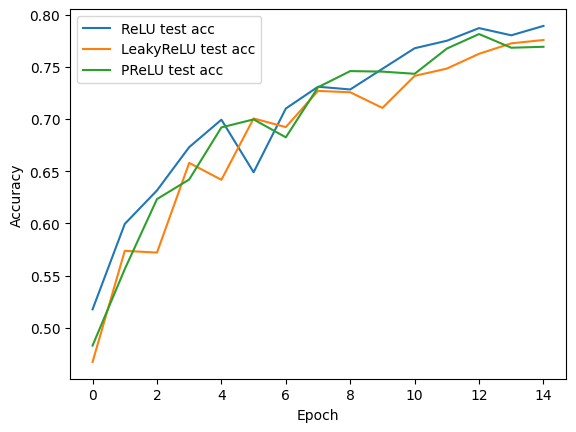

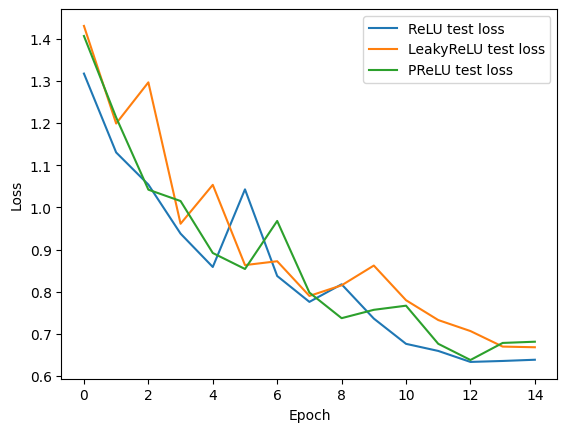

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["relu_test_acc"], label="ReLU test acc")
plt.plot(history["lrelu_test_acc"], label="LeakyReLU test acc")
plt.plot(history["prelu_test_acc"], label="PReLU test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["relu_test_loss"], label="ReLU test loss")
plt.plot(history["lrelu_test_loss"], label="LeakyReLU test loss")
plt.plot(history["prelu_test_loss"], label="PReLU test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Hücre 8 — Son epoch özet

In [9]:
print("Final (last epoch):")
print(f"ReLU : acc={history['relu_test_acc'][-1]:.4f}, loss={history['relu_test_loss'][-1]:.4f}")
print(f"LReLU: acc={history['lrelu_test_acc'][-1]:.4f}, loss={history['lrelu_test_loss'][-1]:.4f}")
print(f"PReLU: acc={history['prelu_test_acc'][-1]:.4f}, loss={history['prelu_test_loss'][-1]:.4f}")

Final (last epoch):
ReLU : acc=0.7893, loss=0.6384
LReLU: acc=0.7758, loss=0.6680
PReLU: acc=0.7693, loss=0.6812


## Eğitim Sonuçları (15 Epoch)  
**ReLU vs LeakyReLU vs PReLU — Aynı mimari, aynı veri seti**

| Epoch | Model | Train Loss | Test Loss | Accuracy |
|------:|:------|-----------:|----------:|---------:|
| 1 | ReLU | 1.5846 | 1.3175 | 0.5176 |
| 1 | LeakyReLU | 1.6041 | 1.4306 | 0.4672 |
| 1 | PReLU | 1.6285 | 1.4067 | 0.4829 |
| 2 | ReLU | 1.2132 | 1.1303 | 0.5995 |
| 2 | LeakyReLU | 1.2574 | 1.1990 | 0.5737 |
| 2 | PReLU | 1.2820 | 1.2134 | 0.5562 |
| 3 | ReLU | 1.0522 | 1.0541 | 0.6316 |
| 3 | LeakyReLU | 1.0858 | 1.2967 | 0.5720 |
| 3 | PReLU | 1.1061 | 1.0420 | 0.6233 |
| 4 | ReLU | 0.9589 | 0.9376 | 0.6731 |
| 4 | LeakyReLU | 0.9914 | 0.9611 | 0.6580 |
| 4 | PReLU | 0.9914 | 1.0150 | 0.6421 |
| 5 | ReLU | 0.8757 | 0.8585 | 0.6994 |
| 5 | LeakyReLU | 0.9260 | 1.0535 | 0.6418 |
| 5 | PReLU | 0.9189 | 0.8917 | 0.6920 |
| 6 | ReLU | 0.8199 | 1.0427 | 0.6490 |
| 6 | LeakyReLU | 0.8628 | 0.8630 | 0.7006 |
| 6 | PReLU | 0.8446 | 0.8538 | 0.6997 |
| 7 | ReLU | 0.7779 | 0.8371 | 0.7101 |
| 7 | LeakyReLU | 0.8182 | 0.8721 | 0.6923 |
| 7 | PReLU | 0.7949 | 0.9678 | 0.6825 |
| 8 | ReLU | 0.7343 | 0.7757 | 0.7310 |
| 8 | LeakyReLU | 0.7713 | 0.7899 | 0.7270 |
| 8 | PReLU | 0.7455 | 0.7978 | 0.7305 |
| 9 | ReLU | 0.7027 | 0.8174 | 0.7284 |
| 9 | LeakyReLU | 0.7365 | 0.8150 | 0.7257 |
| 9 | PReLU | 0.7073 | 0.7370 | 0.7460 |
|10 | ReLU | 0.6711 | 0.7361 | 0.7482 |
|10 | LeakyReLU | 0.7047 | 0.8619 | 0.7107 |
|10 | PReLU | 0.6787 | 0.7569 | 0.7455 |
|11 | ReLU | 0.6439 | 0.6761 | 0.7679 |
|11 | LeakyReLU | 0.6781 | 0.7797 | 0.7414 |
|11 | PReLU | 0.6504 | 0.7667 | 0.7434 |
|12 | ReLU | 0.6234 | 0.6593 | 0.7751 |
|12 | LeakyReLU | 0.6541 | 0.7326 | 0.7484 |
|12 | PReLU | 0.6262 | 0.6762 | 0.7676 |
|13 | ReLU | 0.6045 | 0.6332 | 0.7872 |
|13 | LeakyReLU | 0.6379 | 0.7065 | 0.7626 |
|13 | PReLU | 0.6044 | 0.6378 | 0.7815 |
|14 | ReLU | 0.5922 | 0.6355 | 0.7803 |
|14 | LeakyReLU | 0.6177 | 0.6696 | 0.7726 |
|14 | PReLU | 0.5818 | 0.6783 | 0.7684 |
|15 | ReLU | 0.5730 | 0.6384 | 0.7893 |
|15 | LeakyReLU | 0.6061 | 0.6680 | 0.7758 |
|15 | PReLU | 0.5679 | 0.6812 | 0.7693 |


## Sonuç ve Yorum (ReLU vs LeakyReLU vs PReLU)

Bu deneyde ReLU, LeakyReLU ve PReLU aktivasyon fonksiyonları;  
**aynı mimari**, **aynı attention (SE)**, **aynı veri seti**, **aynı optimizer** ve **aynı epoch sayısı (15)** kullanılarak karşılaştırılmıştır.  
Amaç, yalnızca aktivasyon fonksiyonunun öğrenme sürecine etkisini gözlemlemektir.

### Genel Performans (Final Epoch)

- **ReLU**
  - Accuracy: **0.7893**
  - Test Loss: **0.6384**

- **LeakyReLU**
  - Accuracy: 0.7758
  - Test Loss: 0.6680

- **PReLU**
  - Accuracy: 0.7693
  - Test Loss: 0.6812

**Genel sıralama:**  
**ReLU > LeakyReLU > PReLU**


### Eğitim Süreci Boyunca Gözlemler

- **ReLU**, erken epoch’larda zaman zaman dalgalanma yaşasa da,
  eğitim ilerledikçe daha **keskin karar sınırları** öğrenmiş ve
  **geç epoch’larda belirgin biçimde öne geçmiştir**.
- **LeakyReLU**, özellikle orta epoch’larda (6–10 arası)
  daha **stabil** bir öğrenme göstermiştir ancak
  nihai genelleme performansında ReLU’nun gerisinde kalmıştır.
- **PReLU**, bazı epoch’larda (örneğin 9. epoch) en yüksek doğruluğa ulaşsa da,
  öğrenilebilir negatif eğimin getirdiği ek serbestlik
  bu deneyde **kalıcı bir avantaja dönüşmemiştir**.

### Teknik Yorum (Neden Böyle Oldu?)

- **ReLU**, yeterli epoch verildiğinde:
  - Daha basit bir fonksiyon olması sayesinde
  - Aşırı esnekliğe girmeden
  - Daha güçlü ve kararlı genelleme yapabilmiştir.

- **LeakyReLU**, negatif bölgede gradyan akışını koruduğu için
  optimizasyonu kolaylaştırmış,
  ancak nihai performansta belirleyici bir üstünlük sağlayamamıştır.

- **PReLU**, öğrenilebilir parametreler sayesinde daha esnek olsa da:
  - Ek parametre sayısı
  - Veri setinin büyüklüğü
  - Epoch sayısı
gibi faktörler nedeniyle bu deneyde overfitting eğilimi göstermiştir.


### Sonuç

Bu deney kapsamında:

- **Uzun eğitim süresi ve yeterli epoch sağlandığında → ReLU**
- **Daha stabil ama sınırlı kazanç isteniyorsa → LeakyReLU**
- **Araştırma / ablation / kapasite artırma amaçlı → PReLU**

tercih edilmelidir.

> Bu sonuçlar, kullanılan mimari ve veri seti için geçerlidir;  
> farklı derinlikler, farklı regularization stratejileri veya daha büyük veri setlerinde sonuçlar değişebilir.


## Bu Deneyden Ne Öğrendik?

- Aktivasyon fonksiyonu seçimi, yalnızca nihai doğruluğu değil,
  **eğitim dinamiklerini ve stabiliteyi** doğrudan etkiler.
- Daha esnek bir aktivasyon (LeakyReLU, PReLU) her zaman daha iyi sonuç vermez;
  **veri seti boyutu ve epoch sayısı** belirleyici faktörlerdir.
- Basit görünen ReLU, yeterli eğitim süresi sağlandığında
  **daha güçlü ve tutarlı bir genelleme** yapabilmektedir.


## Kısa Özet (Rapora Koymalık)

- **ReLU**, 15 epoch sonunda en yüksek doğruluğa ulaşarak
  bu deneyde **en iyi genel performansı** göstermiştir.
- **LeakyReLU**, eğitim sürecinde daha stabil olsa da
  nihai performansta ReLU’nun gerisinde kalmıştır.
- **PReLU**, öğrenilebilir negatif eğimi sayesinde esneklik sunsa da,
  bu deneyde ek parametrelerin avantajı kalıcı bir kazanca dönüşmemiştir.


## Pratik Çıkarım

- **Baseline ve uzun eğitim** → ReLU  
- **Stabilite öncelikli senaryolar** → LeakyReLU  
- **Araştırma, ablation ve kapasite artırma** → PReLU  

Bu nedenle aktivasyon fonksiyonu seçimi,
tek başına bir “en iyi” arayışı değil,
**problem, veri ve eğitim stratejisine bağlı bir tasarım kararıdır**.
